# <u>***Real Estate Analytics: Module 3 Assignment*** </u>

In [92]:
import warnings
warnings.simplefilter("ignore")

In [93]:
import sys, os
module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from Code.settings import *
import Code.Util as util
import Code.read_files as read_files
from IPython.display import Markdown, display
import statsmodels.api as sm
from typing import List

colors = ['tab:Blue', 'tab:Green', 'tab:Orange', 'tab:Red', 'tab:Purple', 'tab:Pink', 'tab:Olive', 'tab:Cyan', 'tab:Brown', 'tab:Grey']

pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None 

def printmd(string):
    display(Markdown(string))

## Question 1: Repeat Rent Index VS Hedonic Model


### Q1.1 Sample rent index

The mode intuitive way to calculate rent index for a certain area is to look at the average rent in the sample period. We can still estimate a regression model to reveal this index. More specifically, for each lease (in the full NYC sample, not just the renewal sample), the dependent variable is log of rent, and the independent variable is a set of quarter dummies with the commencement quarter dummy equal to 1 and otherwise 0. Estimate this regression and report results.

### Q1.2 Hedonic model
The key of repeat rent index is that the model controls for all the apartment-level characteristics, while for sample rent index nothing has been controlled yet. To make sample rent index more comparable to repeat rent index, we add more control variables to the regression in Q1.1, called hedonic model. You are expected to add `['log_age', 'log_sqft', "wfh", "wfh_post"]` to the regression model in Q1.1 and estimate again the rent index.


### Q1.3 Comparison

Plot the three models together, with 2004Q1 as 100 for each of them. Why does henomic rent index lie in between? What's the advantages and disadvantages for repeat rent index compared to hedonic model? List one advantage and one disadvantage. 

In [94]:
####################### START YOUR CODE #######################
# hint: you need to estimate two regression models according
# to the tasks, and for Q1.3 you are expected to plot three
# rent indices together inside one picture by re-using codes
# from lecture notes. 
# Some relevant data:
rent = pd.read_pickle(data_path +"/df_rent.pkl")
transaction = pd.read_pickle(data_path + "/nyc_data_20231231.pkl")
repeat_rent, dummy_label = pd.read_pickle(data_path+ "/repeat_rent_packet.pkl")

# QUESTION 1: 

# Part 1: 

# Create the year_quarter categorical variable to be the independent variable in the regression: 
rent['year_quarter'] = rent.old_com_year.astype(str) + "Q" + rent.old_com_qtr.astype(str)
# Create the log rent variable to be the dependent variable in the regression
rent['lg_ner'] = np.log(rent.ner)
# Remove inf and -inf values: 
rent.replace([np.inf, -np.inf], np.nan, inplace=True)
rent.dropna(subset=['lg_ner'], inplace=True)
# Make dummmies:
dummies = pd.get_dummies(rent['year_quarter'])
rent = pd.concat([rent, dummies], axis=1)
rent.drop('year_quarter', axis=1, inplace=True)
dummy_quarters = rent.columns[5:]
# Run regression: 
reg1, _ = util.run_OLS_reg(rent, 'lg_ner',dummy_quarters,intercept=False, verbose=True)

                            OLS Regression Results                            
Dep. Variable:                 lg_ner   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     25.29
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:34:15   Log-Likelihood:                -14419.
No. Observations:               32129   AIC:                         2.903e+04
Df Residuals:                   32031   BIC:                         2.986e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
2000Q2         4.2574      0.046     92.483      0.0

In [95]:
# Part 2

# Create the needed variables in the transaction dataset: 
transaction.rename(columns={"teleworkable_emp3":"wfh"}, inplace=True)
transaction['_post'] = transaction['Expiration_date_monthend'].apply(lambda x: (x.year == 2020 and x.month >= 3) or (x.year >= 2021))
transaction['wfh_post'] = transaction['wfh'] * transaction['_post']
transaction['log_sqft'] = np.log(transaction['Transaction SQFT'])
transaction['log_age'] = np.log(transaction['Age Building'])
# Identify the columns to merge:
transaction_to_merge = transaction[['lease_code','log_age', 'log_sqft','wfh','wfh_post']].copy()
# Merge the needed transaction data to the rent df:
rent = rent.merge(transaction_to_merge, how="inner",on='lease_code')
# Make the list of independent variables: 
independent_vars = list(dummy_quarters) + ['log_age', 'log_sqft','wfh','wfh_post']
# Run regression: 
reg2, _ = util.run_OLS_reg(rent, 'lg_ner',independent_vars ,intercept=False, verbose=True)

                            OLS Regression Results                            
Dep. Variable:                 lg_ner   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     77.33
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:34:17   Log-Likelihood:                -9921.5
No. Observations:               28444   AIC:                         2.005e+04
Df Residuals:                   28342   BIC:                         2.089e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
2000Q2         4.8085      0.050     96.165      0.0

In [96]:
# # Part 2

# # Create the needed variables in the transaction dataset: 
# transaction.rename(columns={"teleworkable_emp3":"wfh"}, inplace=True)
# transaction['_post'] = transaction['Expiration_date_monthend'].apply(lambda x: (x.year == 2020 and x.month >= 3) or (x.year >= 2021))
# transaction['wfh_post'] = transaction['wfh'] * transaction['_post']
# transaction['log_sqft'] = np.log(transaction['Transaction SQFT'])
# transaction['log_age'] = np.log(transaction['Age Building'])
# # Identify the columns to merge
# transaction_to_merge = transaction[['lease_code','log_age', 'log_sqft','wfh','wfh_post']].copy()
# # Merge the needed transaction data to the rent df
# rent = rent.merge(transaction_to_merge, how="inner",on='lease_code')
# # Create the formula fo the regression. We exclude a constant term to avoid the dummy variable trap of perfect multicollinearity.  
# reg_formula = "lg_ner ~ C(year_quarter) + log_age + log_sqft + wfh + wfh_post"
# # Fit the model 
# model = sm.formula.ols(formula=reg_formula, data=rent)
# results2 = model.fit()
# # Report Results 
# print(results2.summary())

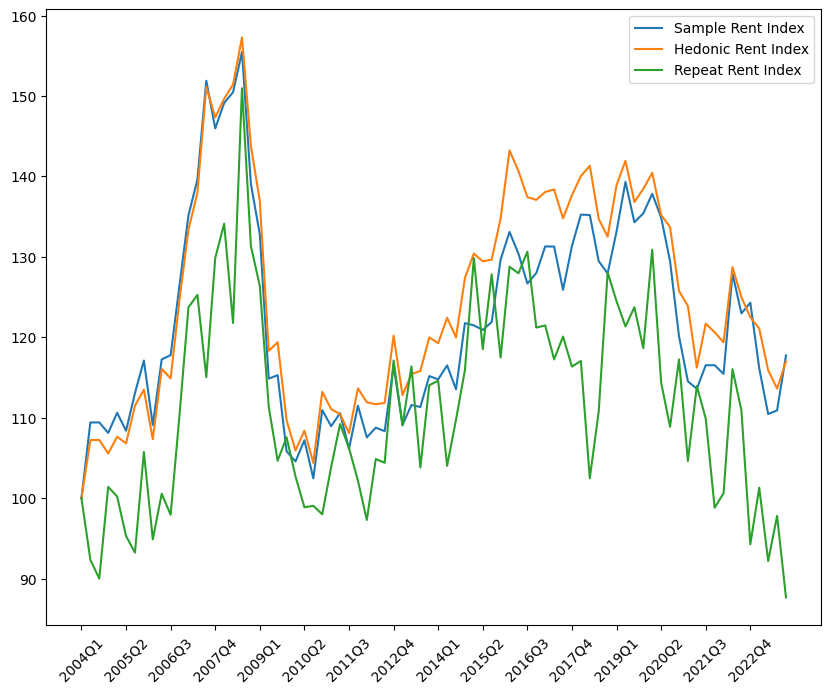

In [97]:
# Part 3

# Get repeat-rent regression values: 
reg3, _ = util.run_OLS_reg(repeat_rent, "price_change", dummy_label, intercept=False, verbose=False) 
# Get params of each model in df: 
reg3_df = reg3.params.reset_index(drop=False)
reg2_df = reg2.params.reset_index(drop=False)
reg1_df = reg1.params.reset_index(drop=False)
# Combine the params into a single df:
all_results = reg3_df.merge(reg2_df, on='index', how='left').merge(reg1_df, on='index', how='left')
all_results.columns = ['year_quarter','repeat_rent','hedonic','sample_rent']
# Calculate the rent indexes:
def make_rent_index(result_col):
    ind_list = [100] # set index starting point to 100 
    for i in range(1, all_results.shape[0]):
        ind_list.append(100 * np.exp(all_results[result_col][i] - all_results[result_col][0])) 
    return ind_list
repeat_rent_index = make_rent_index('repeat_rent')
hedonic_rent_index = make_rent_index('hedonic')
sample_rent_index = make_rent_index('sample_rent')
# Plot the indexes: 
plt.figure(figsize=(10, 8))
plt.plot(all_results.year_quarter, sample_rent_index, label='Sample Rent Index')
plt.plot(all_results.year_quarter, hedonic_rent_index, label='Hedonic Rent Index')
plt.plot(all_results.year_quarter, repeat_rent_index, label='Repeat Rent Index')
plt.legend()
every_5_index = all_results.index % 5 == 0
plt.xticks(all_results.index[every_5_index], all_results.year_quarter[::5], rotation=45) 
plt.show()
######################## END YOUR CODE ########################

Above, we see that the repeat-rent index generally lies considerably below the values for both the sample rent and the hedonic model. This is likely because the repeat-rent index controls for all apartment characteristics by only comparing how values have changed for sales in the same units. Thus, this model would not take into consideration any increases in rents caused by expensive new units being built, and the quality of the total rental stock generally increasing over time. 

One advantage of using a repeat rent index is that it controls for the most apartment characteristics. One disadvantage is that this model is based on less data as it can only include information on units where there have been repeat sales. 

## Question 2: More on Renewal Prediction

During the lecture, we consider the linear probability model for renewal prediction, based on some commonly-used characteristics. There are some more features that are able to add predictive power of renewal activities and also able to be built in CompStak dataset. Specifically, you are expected to involve the following two features in the renewal prediction dataset:

1. `tenant_frac_expiring`: % of leases (in sqft) for the tenant that are expiring within the next 1Y in all of US
2. `tenant_size`: the log of total sqft of properties that the tenant has at least one lease in in the US
(These variables are stored in `'fraction_d2.pkl'`)

In this assignment, you are expected to re-estimate the linear probability model and finish a mini-case. 

### Q2.1 Regression estimation question
1. add the variables to the dataset
2. train a linear probability regression model, similar what we did in the lecture, to predict renewals with new variables together 
3. explain the changes of results for existing variables in the lecture regression, and also the results for the newly-added variables

In [ ]:
df_match, df_nomatch = pd.read_pickle(data_path + "/renewal_prediction_packet.pkl")
print(df_match.shape, df_nomatch.shape)
data_aux = pd.read_pickle(data_path + '/fraction_d2.pkl')


# add tenant features to data
data_aux_tenant = data_aux["Tenant Code"]

# change column names
data_aux_tenant.rename(columns={"Date": "Expiration_date_monthend", "Total_properties": "tenant_size", "fraction_expiring": "tenant_frac_expiring"}, inplace=True)

# define size as logarithm
data_aux_tenant["tenant_size"] = data_aux_tenant["tenant_size"].apply(np.log)

# add variables back to panel

####################### START YOUR CODE #######################
# hint: you are expected to merge it back to our main dfs, which
# are `df_match` and `df_nomatch`. 
######################## END YOUR CODE ########################

# print out shape
print(df_match.shape, df_nomatch.shape)

# run our previous algorithm

####################### START YOUR CODE #######################
# hint: this part is highly overlapped with what we do in the 
# lecture note, just think about what's the difference here
######################## END YOUR CODE ########################

# define the model and estimate the model
model = smf.ols(formula=formula, data=df)
results = model.fit()

print(results.summary())

### Q2.2 Mini-case question

Suppose you are a landlord and one of your tenants has expiring lease this year. You are considering to offer it a temporary one-year extension to keep this tenant for one more year and let it reconsider the renewal later. The main reason is that you know the tenant is aiming at 10% size growth in the future. The tenant/lease information is listed below:

| LeaseType | BuildingClass | wfh | log_last_rent	 | tenant_frac_expiring	 | tenant_size | age	 | log_sqft |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Full Service	 | A | 0.885734	 |3.688879	 | 0.0 | 9.571505 |47 | 8.878497 | 

If your tenant doesn't renew at the end of the one-year extension period, you could find a new tenant for the empty space. For simplicity, assume that the new tenant will start paying rent immediately after the last lease ends. The probability of finding a new tenant is 20% in pandemic and 80% in non-pandemic episode. You only have opportunity to find new tenants at the start of each year. If the space is vacant and you are not able to find a new tenant, you earn nothing; if you succeed in finding a new tenant, you earn the full rent.

If you don't offer the tenant an extension contract, the tenant needs to make decisions right now upon the above information; if you offer the tenant an extension and the tenant picks it, one year later, the rent in the renewal proposal is the same as the last rent, the tenant has 15% of lease expiring and the leasing size doesn't change (i.e. variables `log_last_rent` and `log_sqft` stay constant while `tenant_frac_expiring` becomes 15%).

Questions:
1. what's the tenant's current renewal probability according to the renewal model? (Note: Assume we are currently in pandemic namely the high WFH state.)
2. what's the tenant's future renewal probability if it accepts the extension? You need to figure out results in two scenarios: 1) pandemic is over after year1, or 2) pandemic continues in year2. 
3. how to consider your greatest possible discount in extension contract in rent to make sure you're always better-off no matter whether covid pandemic will continue or not? **Suppose you only maximize the income in the next two years**. The rent for all contracts are the same and normalized to 1, unless there is a discount in the extension contract.